## Class definitions and util functions


In [37]:
%pip install dataclasses

from dataclasses import dataclass
from typing import Literal, Any
from collections import defaultdict
import copy


@dataclass
class Feria:
    cod_comuna: str
    comuna: str
    dias: list[int]
    cantidad_puestos: int


@dataclass
class Producto:
    id: int
    nombre: str
    meses_siembra: list[int]
    meses_venta: list[int]
    dias_cosecha: float
    unidad: Literal["unidades", "kilos"]
    unit_ha: float
    volumen_feriante: float
    volumen_un_consumidor: float
    prob_consumir: float
    costo_ha: float
    prob_compra_feriante: float
    oc: tuple[float, float, float]
    sequias: tuple[float, float, float]
    heladas: tuple[float, float, float]
    plagas: tuple[float, float, float]
    precios_mes: list[float]
    precio_consumidor: float


@dataclass
class Solution:
    items: list[int]
    data: list[Any]

    def get_partitions(self) -> dict[int, list[Any]]:
        partitions = defaultdict(list)
        for idx, item in enumerate(self.items):
            partitions[item].append(self.data[idx])
        return partitions

    def copy(self) -> 'Solution':
        return Solution(items=self.items.copy(), data=self.data.copy())


Note: you may need to restart the kernel to use updated packages.


In [2]:
import json


def read_ferias(file_dir: str) -> list[Feria]:
    with open(file_dir, 'r') as file:
        data = json.load(file)
    ferias = [Feria(**feria) for feria in data]
    return ferias


def read_productos(file_dir: str) -> list[Producto]:
    with open(file_dir, 'r') as file:
        data = json.load(file)
    items = [{"unit_ha" if key == "unit/ha" else key: val for key, val in item.items()}
             for item in data]
    productos = [Producto(**item) for item in items]
    return productos

## Main algorithm and helper functions


### Main implementation of Simulated Annealing


In [3]:
from typing import Any, Callable
from math import sqrt
import random
import math


def simulated_annealing_partitioning(
    items: list[Any],
    n: int,
    f: Callable[..., Any],
    find_neighbour: Callable[..., Any],
    init_temp: float = 1_000,
    temp_threshold: float = 1e-3,
    cooling_rate: float = 0.99,
    debug: bool = False,
    **kwargs,
) -> tuple[Solution, float, list[float], list[float]]:
    """
    Implementación de Simulated Annealing para maximizar una función objetivo dada.
    Params:
        - items: elementos a particionar
        - n: número de particiones a generar
        - f: función objetivo a ser maximizada.
        - find_neighbour: función para encontrar el siguiente vecino a evaluar
        - temp_threshold: umbral para enfriamiento del recocido
        - cooling_rate: tasa de enfriamiento. Reduce geométricamente la temperatura.
    """
    best_score_history = []
    current_score_history = []

    # Generamos solución inicial de forma aleatoria
    initial_assignments = [random.randint(0, n - 1) for _ in items]
    sol = Solution(items=initial_assignments, data=items)
    sol_score = f(sol, **kwargs)
    best_score = sol_score
    best_sol = sol.copy()
    temp = init_temp

    while temp > temp_threshold:
        neighbour = find_neighbour(sol, f, **kwargs)
        new_score = f(neighbour, **kwargs)
        delta = new_score - sol_score

        if delta > 0 or random.uniform(0, 1) < math.exp(delta / temp):
            sol = neighbour
            sol_score = new_score

            if sol_score > best_score:
                best_score = sol_score
                best_sol = sol.copy()

        temp *= cooling_rate
        best_score_history.append(best_score)
        current_score_history.append(sol_score)

        if debug:
            print(f"Best score: {best_score}, Current score: {sol_score}, Temperature: {temp}")

    return best_sol, best_score, best_score_history, current_score_history

### Neighbourhood search functions


In [34]:
def find_next_best_neighbour(
    sol: Solution, f: Callable[..., Any], op: Callable[..., Any], r: int = 1, n_iter: int = 100, **kwargs
) -> Solution:
    """
    Función que implementa procedimiento para encontrar el siguiente mejor vecino.
    Params:
        - sol: Solución que corresponde al punto de inicio de la búsqueda
        - f: Función objetivo para evaluar la calidad de la solución
        - r: Cantidad de veces que se aplica el operador entre vecinos evaluados. Un valor más grande significa que los vecinos evaluados serán más distintos entre sí, mientras que un valor más pequeño evaluará vecinos más cercanos o similares.
        - n_iter: Cantidad máxima de iteraciones hasta detener la búsqueda
        - op: Operador para explorar la vecindad
    """
    score = f(sol, **kwargs)
    best_sol = sol
    best_score = score

    for _ in range(n_iter):
        new_sol = sol.copy()
        for _ in range(r):
            new_sol = op(new_sol, **kwargs)
        new_score = f(new_sol, **kwargs)
        if new_score > best_score:
            return new_sol
    return best_sol


def adaptive_next_neighbour(
    sol: Solution, f: Callable, g: Callable[list, list], r: int = 1, **kwargs
) -> Solution:
    """
    Función que encuentra el siguiente vecino en función de la distribución actual de 
    carga de cómputo. Usa una función greedy g() para determinar la carga relativa de cada
    partición, para luego intercambiar r elementos de la partición con más carga con la 
    con menor carga.
    """
    new_sol = sol.copy()

    for _ in range(r):
        partitions = new_sol.get_partitions()
        partitions_score = {k: g(items) for k, items in partitions.items()}
        min_part = min(partitions_score, key=partitions_score.get)
        max_part = max(partitions_score, key=partitions_score.get)

        if not partitions[min_part] or not partitions[max_part]:
            continue

        item_min = random.choice(partitions[min_part])
        item_max = random.choice(partitions[max_part])

        idx_min = new_sol.data.index(item_min)
        idx_max = new_sol.data.index(item_max)

        # Intercambiamos los asignamientos
        new_sol.items[idx_min], new_sol.items[idx_max] = new_sol.items[idx_max], new_sol.items[idx_min]

    return new_sol

def move_operator(sol: Solution, f: Callable[..., Any], **kwargs) -> Solution:
    """
    Mueve un elemento a una partición diferente.
    """
    new_sol = copy.deepcopy(sol)
    idx = random.randint(0, len(new_sol.items) - 1)
    new_partition = random.randint(0, max(new_sol.items))
    new_sol.items[idx] = new_partition
    return new_sol

def shaker_operator(
    sol: Solution
) -> Solution:
    """
    Intercambia dos elementos al azar de una solución
    """
    new_sol = sol.copy()
    # Elegimos dos índices al azar
    idx1, idx2 = random.sample(range(len(new_sol.items)), 2)
    # Intercambiamos los valores
    new_sol.items[idx1], new_sol.items[idx2] = new_sol.items[idx2], new_sol.items[idx1]
    return new_sol

### Product objective functions


In [5]:
def productos_naive_objective_function(sol: Solution, **_) -> float:
    """
    Función similar a lo implementado en la primera versión del particionador.
    Encuentra un centroide que representa la distribución ideal por mes del año y 
    calcula la distancia con respecto a ese vector.
    """

    # Obtenemos las particiones
    num_items = len(sol.data)
    centroid = [0] * 12

    # Calculamos el centroide
    for prod in sol.data:
        for mes in prod.meses_venta:
            centroid[mes] += 1
    centroid = [x / num_items for x in centroid]

    diff = 0.0
    partitions = sol.get_partitions()
    for partition in partitions.values():
        vector = [0] * 12
        for prod in partition:
            for mes in prod.meses_venta:
                vector[mes] += 1
        vector = [x / num_items for x in vector]
        diff += sum(abs(x - y) for x, y in zip(vector, centroid))

    return -diff


def productos_weighted_naive_objective_function(sol: Solution, **_) -> float:
    """
    Similar a la versión anterior, pero pondera por la probabilidad de compra
    de feriante - que debería ser un valor proxy para la cantidad de trabajo asociado a 
    ese producto.
    """

    # Obtenemos las particiones
    partitions = sol.get_partitions()

    # Calculamos centroide inicial
    centroid = [0] * 12
    for prod in sol.data:
        for mes in prod.meses_venta:
            centroid[mes] += prod.prob_compra_feriante

    # Calculamos el vector para cada partición y calculamos la diferencia
    diff = 0.0
    for partition in partitions.values():
        vector = [
            prod.prob_compra_feriante for mes in prod.meses_venta for prod in partition]
        diff += sum(map(lambda x, y: (x - y)**2, vector, centroid))
    return -sqrt(diff)


def productos_penalized_weighted_obj_function(sol: Solution, penalty: float = 0.1, **kwargs) -> float:
    """
    Esta implementación abandona la idea de un centroide ideal.
    Más bien, se intenta maximizar la cantidad de cómputo de cada partición.
    Además, si una partición no tiene cómputo para algún mes de la simulación, 
    se le penaliza.
    """

    partitions = sol.get_partitions()
    total_score = 0.0

    for partition in partitions.values():
        months = [0.0] * 12
        for prod in partition:
            for mes in prod.meses_venta:
                months[mes] += prod.prob_compra_feriante
        # Penalizamos los meses sin actividad
        partition_score = sum(month if month > 0 else -penalty for month in months)
        total_score += partition_score

    return total_score


def producto_partition_greedy_function(partition: list[Producto], penalty: float = 0.1) -> float:
    months = [0.0] * 12
    score = 0.0
    for prod in partition:
        for active_month in prod.meses_venta:
            months[active_month] += prod.prob_compra_feriante
    for month in months:
        score += month if month else -penalty

    return score

### Ferias objective functions


In [19]:
def feria_penalized_objective_function(sol: Solution, penalty: float = 200, **_):
    partitions = sol.get_partitions()
    scores = []
    # Recorremos las particiones y obtenemos sus puntajes respectivos
    for partition in partitions.values():
        score = 0.0
        vector = [0.0] * 7
        for feria in partition:
            for dia in feria.dias:
                vector[dia] += feria.cantidad_puestos
        for dia in vector:
            score += dia if dia else -penalty
        scores.append(score)

    return min(scores)

## Executions and plotting


In [27]:

ferias = read_ferias('../inputs/ferias.json')

productos = read_productos('../inputs/prods.json')
# Registramos las funciones objetivo a evaluar
obj_functions = [
    ('naive', productos_naive_objective_function),
    ('weighted', productos_weighted_naive_objective_function),
    ('penalized_weighted', productos_penalized_weighted_obj_function),
]

In [22]:

eval_data = {}

for name, func in obj_functions:
    sol, score, best_score_history, current_score_history = simulated_annealing_partitioning(
        items=productos,
        n=8,
        f=productos_weighted_naive_objective_function,
        find_neighbour=find_next_best_neighbour,
        op=shaker_operator,
        r=1,
        cooling_rate=0.999
    )

    eval_data.update({name: {"best_score": score, "best_score_history": best_score_history,
                     "solution": sol, "current_score_history": current_score_history}})

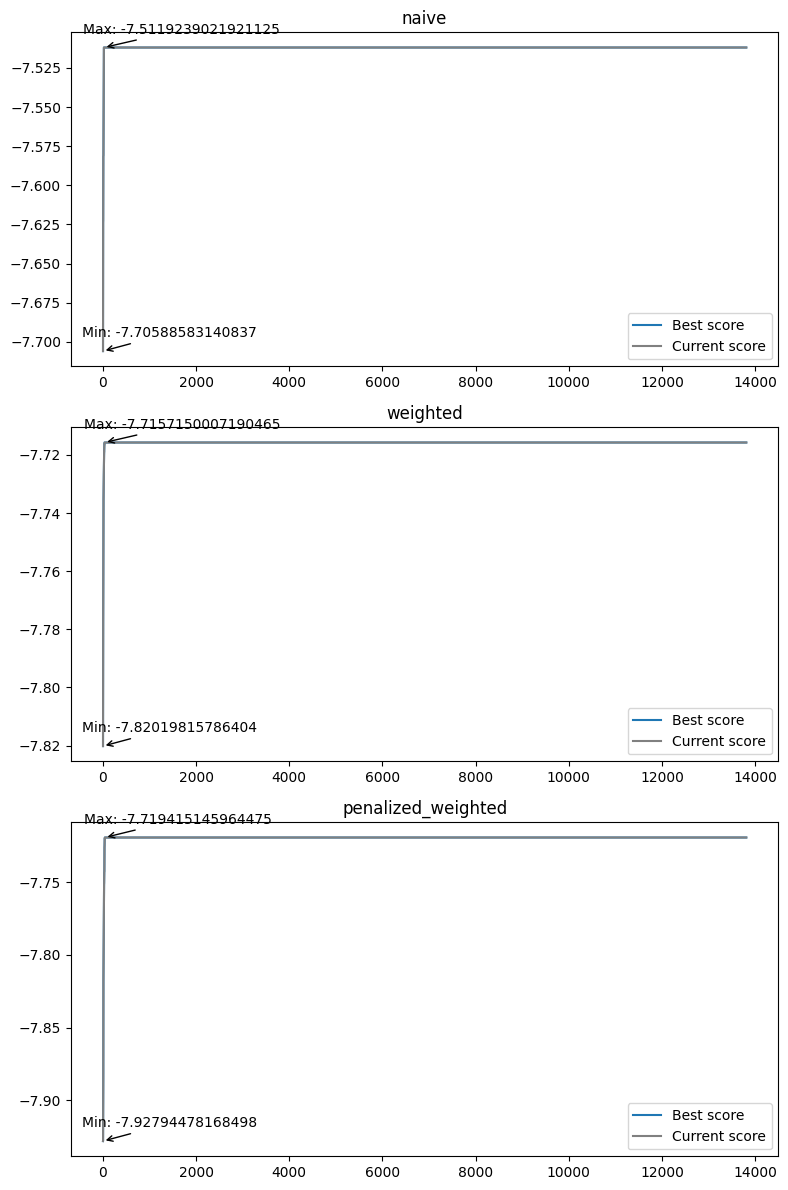

In [23]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(len(eval_data), 1, figsize=(8, len(eval_data) * 4))

for i, (name, data) in enumerate(eval_data.items()):
    x_vals = list(range(1, len(data["best_score_history"]) + 1))
    best_y_vals = data["best_score_history"]
    current_y_vals = data["current_score_history"]

    axs[i].plot(x_vals, best_y_vals, label="Best score")
    axs[i].plot(x_vals, current_y_vals, label="Current score", color="grey")

    min_best, max_best = min(best_y_vals), max(best_y_vals)
    min_curr, max_curr = min(current_y_vals), max(current_y_vals)

    axs[i].annotate(f"Min: {min_best}", xy=(best_y_vals.index(min_best), min_best),
                    xytext=(-15, 10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
    axs[i].annotate(f"Max: {max_best}", xy=(best_y_vals.index(max_best), max_best),
                    xytext=(-15, 10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
    # axs[i].annotate(f"Min: {min_curr}", xy=(current_y_vals.index(min_curr), min_curr), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
    # axs[i].annotate(f"Min: {max_curr}", xy=(current_y_vals.index(max_curr), max_curr), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))

    # Set title and legend
    axs[i].set_title(name)
    axs[i].legend()

# Show the figure
plt.tight_layout()
plt.show()

In [32]:
eval_data = {}

for name, func in obj_functions:
    sol, score, best_score_history, current_score_history = simulated_annealing_partitioning(
        items=productos,
        n=8,
        f=productos_weighted_naive_objective_function,
        find_neighbour=adaptive_next_neighbour,
        op=shaker_operator,
        r=1,
        cooling_rate=0.999,
        g=producto_partition_greedy_function,
    )

    eval_data.update({name: {"best_score": score, "best_score_history": best_score_history,
                     "solution": sol, "current_score_history": current_score_history}})

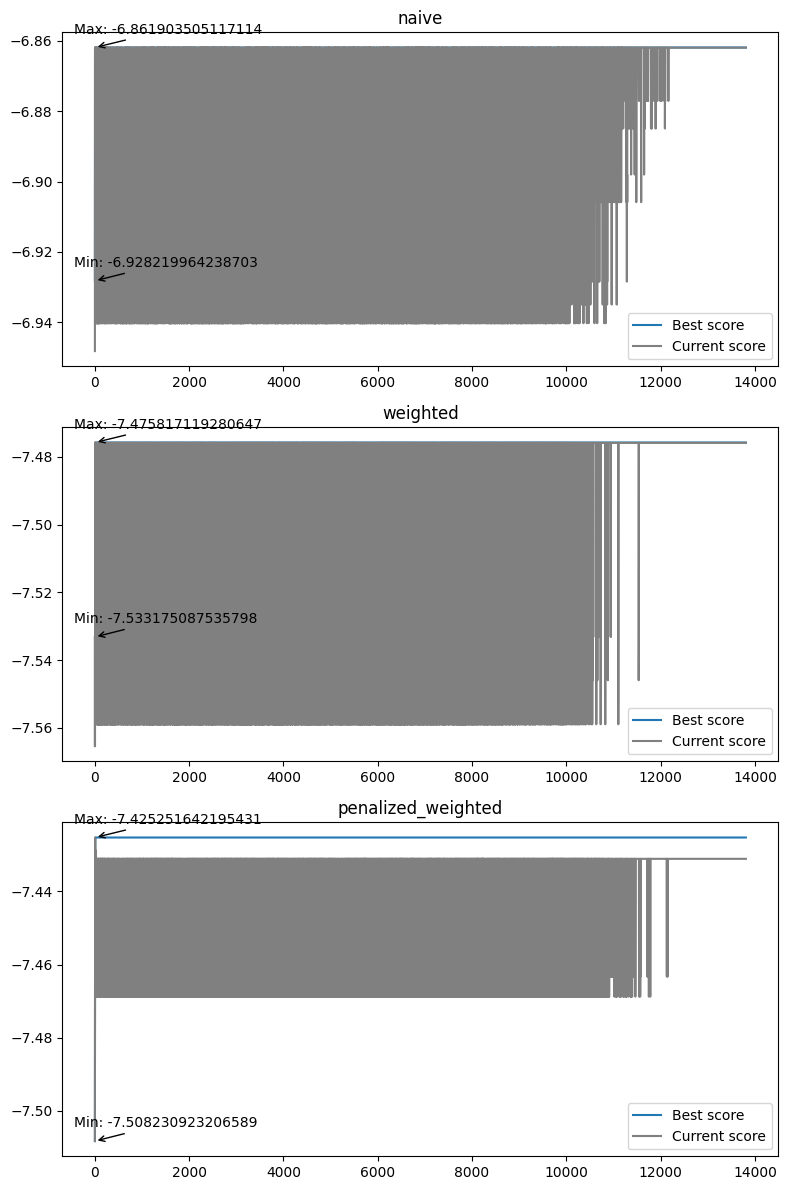

In [25]:
fig, axs = plt.subplots(len(eval_data), 1, figsize=(8, len(eval_data) * 4))

for i, (name, data) in enumerate(eval_data.items()):
    x_vals = list(range(1, len(data["best_score_history"]) + 1))
    best_y_vals = data["best_score_history"]
    current_y_vals = data["current_score_history"]

    axs[i].plot(x_vals, best_y_vals, label="Best score")
    axs[i].plot(x_vals, current_y_vals, label="Current score", color="grey")

    min_best, max_best = min(best_y_vals), max(best_y_vals)
    min_curr, max_curr = min(current_y_vals), max(current_y_vals)

    axs[i].annotate(f"Min: {min_best}", xy=(best_y_vals.index(min_best), min_best),
                    xytext=(-15, 10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
    axs[i].annotate(f"Max: {max_best}", xy=(best_y_vals.index(max_best), max_best),
                    xytext=(-15, 10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
    # axs[i].annotate(f"Min: {min_curr}", xy=(current_y_vals.index(min_curr), min_curr), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
    # axs[i].annotate(f"Min: {max_curr}", xy=(current_y_vals.index(max_curr), max_curr), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))

    # Set title and legend
    axs[i].set_title(name)
    axs[i].legend()

# Show the figure
plt.tight_layout()
plt.show()

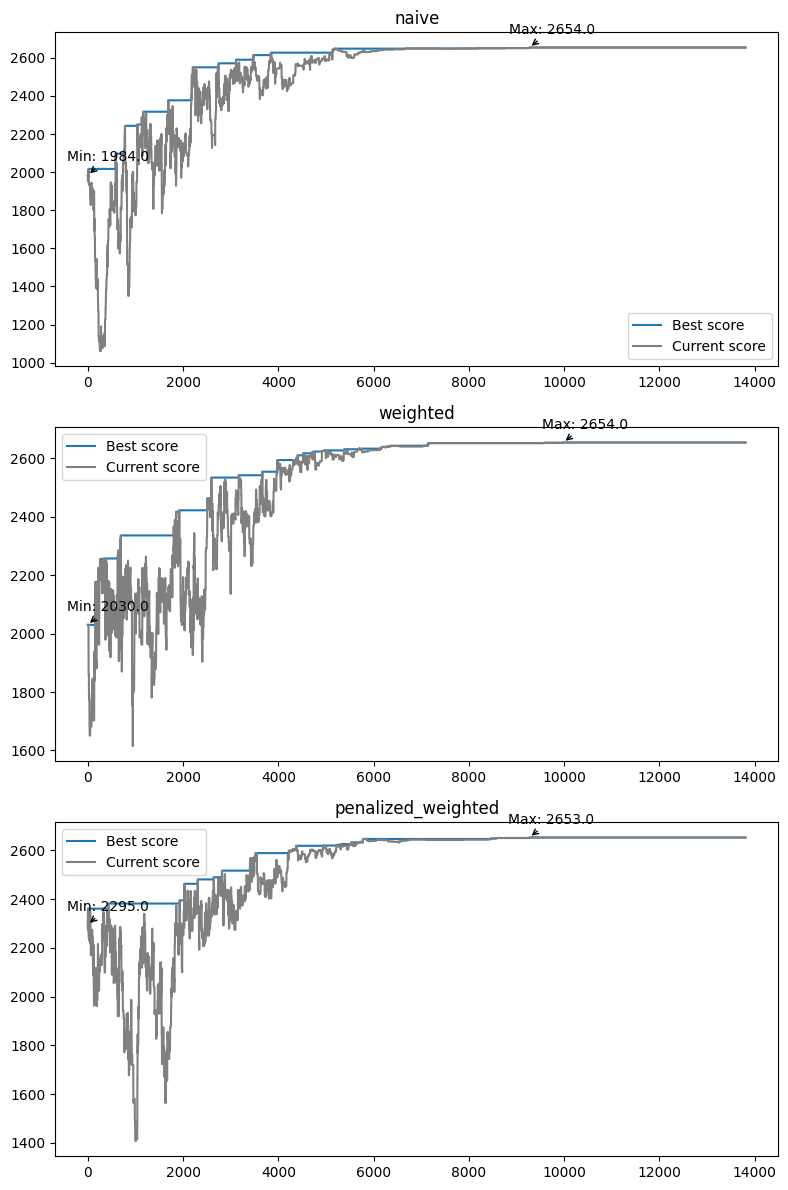

In [40]:
eval_data = {}

for name, func in obj_functions:
    sol, score, best_score_history, current_score_history = simulated_annealing_partitioning(
        items=ferias,
        n=8,
        f=feria_penalized_objective_function,
        find_neighbour=move_operator,
        op=shaker_operator,
        r=1,
        cooling_rate=0.999,
        g=producto_partition_greedy_function,
    )

    eval_data.update({name: {"best_score": score, "best_score_history": best_score_history,
                     "solution": sol, "current_score_history": current_score_history}})

fig, axs = plt.subplots(len(eval_data), 1, figsize=(8, len(eval_data) * 4))

for i, (name, data) in enumerate(eval_data.items()):
    x_vals = list(range(1, len(data["best_score_history"]) + 1))
    best_y_vals = data["best_score_history"]
    current_y_vals = data["current_score_history"]

    axs[i].plot(x_vals, best_y_vals, label="Best score")
    axs[i].plot(x_vals, current_y_vals, label="Current score", color="grey")

    min_best, max_best = min(best_y_vals), max(best_y_vals)
    min_curr, max_curr = min(current_y_vals), max(current_y_vals)

    axs[i].annotate(f"Min: {min_best}", xy=(best_y_vals.index(min_best), min_best),
                    xytext=(-15, 10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
    axs[i].annotate(f"Max: {max_best}", xy=(best_y_vals.index(max_best), max_best),
                    xytext=(-15, 10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
    # axs[i].annotate(f"Min: {min_curr}", xy=(current_y_vals.index(min_curr), min_curr), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
    # axs[i].annotate(f"Min: {max_curr}", xy=(current_y_vals.index(max_curr), max_curr), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))

    # Set title and legend
    axs[i].set_title(name)
    axs[i].legend()

# Show the figure
plt.tight_layout()
plt.show()

Best score: 1943.0, Current score: 1943.0, Temperature: 990.0
Best score: 1945.0, Current score: 1945.0, Temperature: 980.1
Best score: 1971.0, Current score: 1971.0, Temperature: 970.299
Best score: 1992.0, Current score: 1992.0, Temperature: 960.59601
Best score: 2044.0, Current score: 2044.0, Temperature: 950.9900498999999
Best score: 2070.0, Current score: 2070.0, Temperature: 941.480149401
Best score: 2077.0, Current score: 2077.0, Temperature: 932.0653479069899
Best score: 2086.0, Current score: 2086.0, Temperature: 922.74469442792
Best score: 2191.0, Current score: 2191.0, Temperature: 913.5172474836407
Best score: 2206.0, Current score: 2206.0, Temperature: 904.3820750088043
Best score: 2212.0, Current score: 2212.0, Temperature: 895.3382542587163
Best score: 2234.0, Current score: 2234.0, Temperature: 886.3848717161292
Best score: 2234.0, Current score: 2234.0, Temperature: 877.5210229989679
Best score: 2234.0, Current score: 2234.0, Temperature: 868.7458127689781
Best score: 

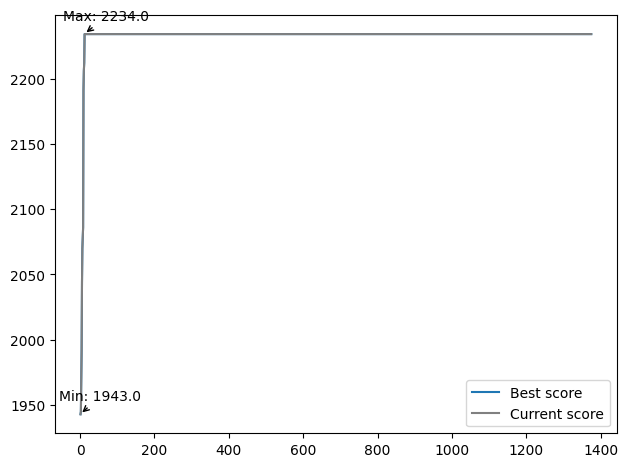

In [21]:
sol, score, best_score_history, current_score_history = simulated_annealing_partitioning(
    items=ferias,
    n=8,
    f=feria_penalized_objective_function,
    find_neighbour=find_next_best_neighbour,
    op=shaker_operator,
    r=1,
    cooling_rate=0.99,
    debug=True
)


# Create a figure and axis using plt.subplots()
fig, ax = plt.subplots()

x_vals = list(range(1, len(best_score_history) + 1))
best_y_vals = best_score_history
current_y_vals = current_score_history
ax.plot(x_vals, best_y_vals, label="Best score")
ax.plot(x_vals, current_score_history, label="Current score", color="grey")


min_best, max_best = min(best_y_vals), max(best_y_vals)
min_curr, max_curr = min(current_y_vals), max(current_y_vals)

ax.annotate(f"Min: {min_best}", xy=(best_y_vals.index(min_best), min_best),
            xytext=(-15, 10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
ax.annotate(f"Max: {max_best}", xy=(best_y_vals.index(max_best), max_best),
            xytext=(-15, 10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))

ax.legend()

# Show the figure
plt.tight_layout()
plt.show()

In [42]:
sol.get_partitions()[0][0] == Feria(**sol.get_partitions()[0][0].__dict__)

True